<a href="https://colab.research.google.com/github/aspiringastro/anlp-cmu/blob/main/SDSS_Galaxy_Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import requests
import os
from IPython.display import Image, display
from pathlib import Path

import pandas as pd
import numpy as np
from google.colab import drive
import re

In [15]:
!pip install -qq fastai

In [16]:
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
from fastai.vision.all import *

In [17]:

# Morphological classifications of SDSS main sample spectroscopic galaxies from Galaxy Zoo 2. This data is used to establish the labeled classification built through human agents.
# There are 239,695 galaxies in total in this dataset
hdf = pd.read_csv('http://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz', compression='gzip')
hart_morph_classes = hdf.gz2_class.unique()
print(f'Number of Hart16 morphological galaxy classes: {len(hart_morph_classes)}')

Number of Hart16 morphological galaxy classes: 818


In [18]:
def sdss_get_params(ra, dec, scale=0.2, width=256, height=256, opt=''):
    return {
        'TaskName': 'Skyserver.Chart.Navi',
        'ra'      : ra,
        'dec'     : dec,
        'scale'   : scale,
        'width'   : width,
        'height'  : height,
        'opt'     : opt
    }


def sdss_download_image(dest_path, params, filename, force=False):
    base_url='http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg'
    image_file = f'{dest_path}/{filename}.jpg'
    image_path = Path(image_file)
    if image_path.is_file() and force == False:
        return { 'success': True, 'file': image_file, 'code': 303 }
    resp = requests.get(base_url, params)
    if resp.status_code == 200:
        with open(image_file, 'wb') as f:
            f.write(resp.content)
        return { 'success': True, 'file': image_file, 'code': resp.status_code }
    else:
        return { 'success': False, 'file': image_file, 'code': resp.status_code }


def sdss_download_dataset(hdf, morph_class, base_path, per_class_limit=25):
    image_count = 0
    mb = master_bar(range(len(morph_class)))
    for i in mb:
        mc=morph_class[i]
        mc_path = f'{base_path}/{mc}'
        os.makedirs(mc_path, exist_ok=True)
        mb.main_bar.comment = f'{mc} Class'
        image_list = ([name for name in os.listdir(mc_path) if os.path.isfile(os.path.join(mc_path, name))])
        sample_requested = per_class_limit - len(image_list)
        if len(image_list) >= per_class_limit:
          continue
        rows = hdf[hdf['gz2_class'] == mc]
        unique_objects = rows.dr7objid.unique()
        if rows.shape[0] < sample_requested:
          sample_requested = rows.shape[0]
        sample_downloaded = 0
        print(f'{mc} : {len(image_list)} : {len(unique_objects)}')
        for j, row in rows.iterrows():
            result = sdss_download_image(mc_path, sdss_get_params(
                        row['ra'], 
                        row['dec']),
                        row['dr7objid'])
            if result['success']:
                if result['code'] == 200:
                  sample_downloaded += 1
            else:
                print(f"Download failed    : {result['file']} [{result['code']}]!")
            # print(f'{j} : {row["dr7objid"]} {result["code"]} sample downloaded: {sample_downloaded}, sample requested: {sample_requested}')
            if sample_downloaded == sample_requested:
              break
        # if sample_downloaded > 0:
        #   print(f'current: {len(image_list)}, requested: {per_class_limit}, Downloaded {sample_downloaded} / {sample_requested} of {mc}')



In [19]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_path = "/content/gdrive/My Drive/colab/datasets/sdss-train"
sdss_download_dataset(hdf, hart_morph_classes, base_path)

In [ ]:
test_path = "/content/gdrive/My Drive/colab/datasets/sdss-test"
sdss_download_dataset(hdf, hart_morph_classes, test_path, per_class_limit=6)

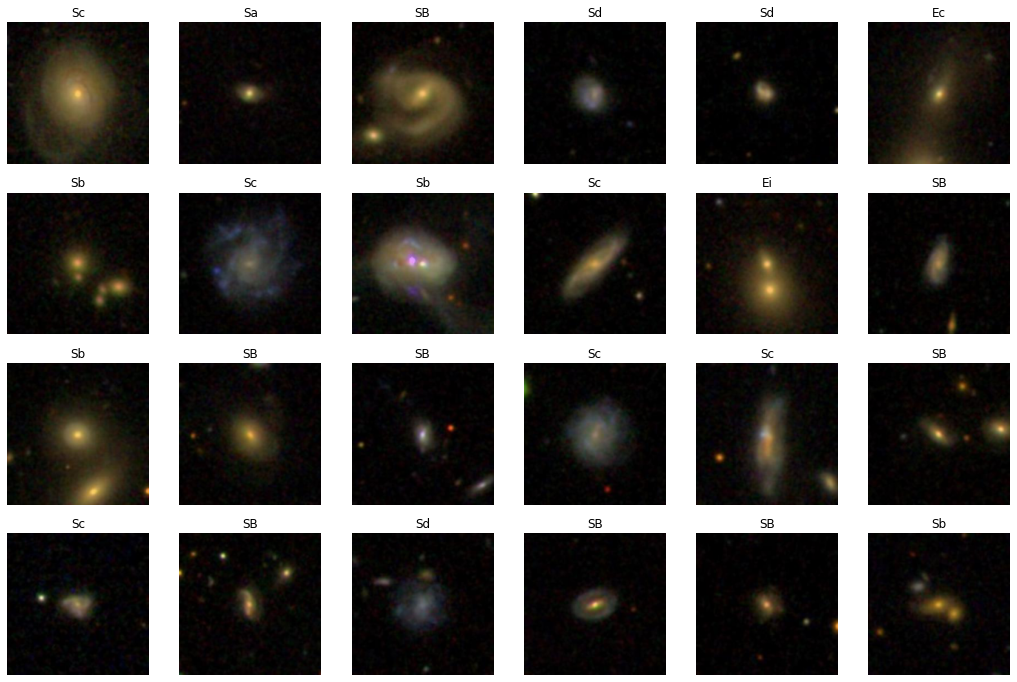

In [20]:
base_path = "/content/gdrive/My Drive/colab/datasets/sdss-train"

def get_parent_label(o, prefix = 2):
  return Path(o).parent.name if prefix == None else re.sub("[^A-Z]", "", Path(o).parent.name[0:prefix],0,re.IGNORECASE) 

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(base_path, bs=128)

dls.show_batch(max_n=24)

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5, base_lr=0.01)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.348485,1.708625,0.650020,00:57


epoch,train_loss,valid_loss,error_rate,time
0,1.519025,1.561800,0.567440,00:58
1,1.408923,1.481708,0.562721,00:58
2,1.167183,1.657552,0.562328,00:58
3,0.623468,1.993268,0.540700,00:58
4,0.203833,2.004827,0.546598,01:00


In [13]:
def test_prediction(hdf, files):
  positive = 0
  negative = 0
  df = pd.DataFrame(columns=["object_id", "gz2_class", "target_class", "predict_class", "prob_0", "prob_1", "positive", "negative"])

  for f in files:
    object_id = np.int64(os.path.basename(f).split('.')[0])
    gz2_class = hdf[hdf.dr7objid == object_id]['gz2_class'].tolist()
    target_class = list(map(lambda c: c[0:3], gz2_class))
    predict_class, _, probs = learn.predict(PILImage.create(f))

    #print(f"Predicted Class={predict_class}, Confidence: {probs[0]:.2f} {probs[1]:.2f}, Target Class: {target_class}")
    if predict_class in target_class:
      positive += 1
    else:
      negative += 1
    entry = pd.DataFrame.from_dict({
      "object_id": object_id,
      "gz2_class": gz2_class,
      "target_class": target_class,
      "predict_class": predict_class,
      "prob_0": probs[0],
      "prob_1": probs[1],
      "positive": predict_class in target_class,
      "negative": predict_class in target_class
    })

    df = pd.concat([df, entry], ignore_index=True)

  return df


test_df = test_prediction(hdf, get_image_files(base_path))
success = test_df['positive'].values.sum()
failure = test_df['negative'].values.sum()
print(f'Resnet18: success = {success}, failure = {failure}, TP Accuracy: {success/(success + failure):.4f}')
test_df.head(20)

TypeError: ignored

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)
test_df = test_prediction(hdf, get_image_files(base_path))
success = test_df['positive'].values.sum()
failure = test_df['negative'].values.sum()
print(f'Resnet34: ') success = {success}, failure = {failure}, TP Accuracy: {success/(success + failure):.4f}')
test_df.head(20)